# testing for post-training processor

In [1]:
import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [3]:
from keras.models import load_model

In [4]:
import uproot
from coffea import hist, util
import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.util import save, load

## load model

In [5]:
path = !pwd

model = load_model(path[0])

In [41]:
path

['/udrive/student/abraukman2020/PhotonClassification']

In [63]:
load_model('/udrive/student/abraukman2020/PhotonClassification')

## load data

In [6]:
#Define files to run over
skimDir="/udrive/staff/dnoonan/Skims"

fileset = {"TTGamma":[f"{skimDir}/TTGamma_SingleLept_2016_skim.root"],
           "TTbar":[f"{skimDir}/TTbarPowheg_Semilept_2016_skim_1of10.root",
                    f"{skimDir}/TTbarPowheg_Semilept_2016_skim_2of10.root"],
          }

filesetData = {"DataMu":[f"{skimDir}/Data_SingleMu_b_2016_skim_1of10.root"],
              }

In [7]:
np.warnings.filterwarnings('ignore')

#the NanoAODSchema needs to be adjusted, to remove cross references to FSRPhotons
class SkimmedSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        super().__init__(base_form)

In [8]:
# events from TTGamma
events = NanoEventsFactory.from_root(fileset["TTGamma"][0],
                                     schemaclass=SkimmedSchema,
                                     entry_stop=10000).events()

dataset = "TTGamma"

In [9]:
######## object & event selection ########
# muons
muons=events.Muon
muonSelectTight = ((muons.pt>30) &
                   (abs(muons.eta)<2.4) &
                   (muons.tightId) &
                   (muons.pfRelIso04_all < 0.15)
                  )
tightMuons = muons[muonSelectTight]

# jets & b-tagged jets
jets=events.Jet
jetSelectTight = ((jets.pt>30) &
                  (abs(jets.eta)<2.4) &
                  (jets.isTight)
                 )
btaggedJetSelect = (jetSelectTight &
                   (jets.btagDeepB>0.6321)
                  )
tightJets = jets[jetSelectTight]
tightBJets = jets[btaggedJetSelect]

# electrons
electrons=events.Electron
electronSelectTight = ((electrons.pt> 35) &
                       (abs(electrons.eta)<2.1) &
                       electrons.cutBased>=4 # tight cut-based ID
                      )
tightEle = electrons[electronSelectTight]


# delta R cuts
phoMu, phoMuDR = events.Photon.nearest(tightMuons,return_metric=True)
phoMuMask = ak.fill_none(phoMuDR>0.4,True)

phoJet, phoJetDR = events.Photon.nearest(tightJets,return_metric=True)
phoJetMask = ak.fill_none(phoJetDR>0.4,True)


# photons
photons = events.Photon
photonSelect= ((photons.pt>20) &
               (abs(photons.eta) < 1.4442) &
               (photons.isScEtaEE | photons.isScEtaEB) &
               (photons.electronVeto) & 
               np.invert(photons.pixelSeed) &
               phoMuMask & phoJetMask
               )
tightPhotons = photons[photonSelect]

tightPhoMu, tightPhoMuDR = tightPhotons.nearest(tightMuons,return_metric=True)
tightPhoJet, tightPhoJetDR = tightPhotons.nearest(tightJets,return_metric=True)
        

# events
trigger = events.HLT.IsoMu24 | events.HLT.IsoTkMu24

eventSelection = (trigger &
                  (ak.num(tightMuons)==1) &
                  (ak.num(tightJets)>=4) & 
                  (ak.num(tightBJets)>=1) &
                  (ak.num(tightEle)==0) &
                  (ak.num(tightPhotons)>=1))

In [10]:
############## prediction ###############
X = pd.DataFrame({
    'photon_pt': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pt)),
    'photon_eta': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].eta)),
    'photon_phi': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].phi)),
    'photon_hoe': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].hoe)),
    'photon_r9': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].r9)),
    'photon_sieie': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].sieie)),
    'photon_pfRelIso03_all': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_all)),
    'photon_pfRelIso03_chg': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_chg)),
    'deltaR_photon_lepton': ak.to_numpy(ak.flatten(tightPhoMuDR[eventSelection])),
    'deltaR_photon_jet': ak.to_numpy(ak.flatten(tightPhoJetDR[eventSelection])),
})

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pt)).shape

(535,)

In [12]:
y_pred = model.predict(X_scaled)
y_pred.shape

(535, 1)

In [13]:
y_pred = y_pred.reshape(y_pred.shape[0])
y_pred.shape

(535,)

## histograms

In [14]:
# declare axes
dataset_axis = hist.Cat("dataset","Dataset")

photon_pt_axis = hist.Bin("pt","$p_{T}$ [GeV]", 40, 0, 200)
photon_eta_axis = hist.Bin("eta","$\eta$", 50, -2, 2)
photon_phi_axis = hist.Bin("phi","$\phi$", 64, -3.2, 3.2)
photon_reliso_all_axis = hist.Bin("reliso","pfRelIso03_all", 40, 0, 0.2)
photon_reliso_chg_axis = hist.Bin("reliso","pfRelIso03_chg", 40, 0, 0.2)
photon_sieie_axis = hist.Bin("sieie","$\sigma_{i\eta i\eta}$", 40, 0, 0.03)
photon_r9_axis = hist.Bin("r9","R9", 40, 0.2, 1.1)
photon_hoe_axis = hist.Bin("hoe","H over E", 40, 0, 0.1)

mu_deltar_axis = hist.Bin("deltar","$\Delta R$: photon-muon", 50, 0, 4)
jet_deltar_axis = hist.Bin("deltar","$\Delta R$: photon-jet", 50, 0, 4)

mvaid_axis = hist.Bin("mvaid", "mvaID", 25,-1,1)

flavLabel_axis = hist.Bin("flav",None,[0,1,2])
photon_genPartFlav_axis = hist.Bin("flav","genPartFlav",14,0,14)
prediction_axis = hist.Bin("pred","Prediction",30,0,1)

In [15]:
# create histograms
photon_pt_hist = hist.Hist("Counts", dataset_axis, photon_pt_axis, flavLabel_axis)
photon_eta_hist = hist.Hist("Counts", dataset_axis, photon_eta_axis, flavLabel_axis)
photon_phi_hist = hist.Hist("Counts", dataset_axis, photon_phi_axis, flavLabel_axis)
photon_reliso_all_hist = hist.Hist("Counts", dataset_axis, photon_reliso_all_axis, flavLabel_axis)
photon_reliso_chg_hist = hist.Hist("Counts", dataset_axis, photon_reliso_chg_axis, flavLabel_axis)
photon_sieie_hist = hist.Hist("Counts", dataset_axis, photon_sieie_axis, flavLabel_axis)
photon_r9_hist = hist.Hist("Counts", dataset_axis, photon_r9_axis, flavLabel_axis)
photon_hoe_hist = hist.Hist("Counts", dataset_axis, photon_hoe_axis, flavLabel_axis)
deltaR_photon_lepton_hist = hist.Hist("Counts", dataset_axis, mu_deltar_axis, flavLabel_axis)
deltaR_photon_jet_hist = hist.Hist("Counts", dataset_axis, jet_deltar_axis, flavLabel_axis)

photon_mvaid_hist = hist.Hist("Counts", dataset_axis, mvaid_axis, flavLabel_axis)
photon_genPartFlav_hist = hist.Hist("Counts", dataset_axis, photon_genPartFlav_axis)
prediction_hist = hist.Hist("Counts", dataset_axis, prediction_axis, flavLabel_axis)

In [16]:
# fill histograms
flavLabel = ak.to_numpy(ak.flatten(tightPhotons[eventSelection].genPartFlav))
flavLabel[flavLabel == 13] = 0 # relabel prompt electrons as fake photons

photon_pt_hist.fill(dataset=dataset, flav=flavLabel,
                    pt=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pt)))
photon_eta_hist.fill(dataset=dataset, flav=flavLabel,
                     eta=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].eta)))
photon_phi_hist.fill(dataset=dataset, flav=flavLabel,
                     phi=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].phi)))
photon_reliso_all_hist.fill(dataset=dataset, flav=flavLabel,
                            reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_all)))
photon_reliso_chg_hist.fill(dataset=dataset, flav=flavLabel,
                            reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_chg)))
photon_sieie_hist.fill(dataset=dataset, flav=flavLabel,
                       sieie=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].sieie)))
photon_r9_hist.fill(dataset=dataset, flav=flavLabel,
                    r9=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].r9)))
photon_hoe_hist.fill(dataset=dataset, flav=flavLabel,
                     hoe=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].hoe)))
deltaR_photon_lepton_hist.fill(dataset=dataset, flav=flavLabel,
                               deltar=ak.to_numpy(ak.flatten(tightPhoMuDR[eventSelection])))
deltaR_photon_jet_hist.fill(dataset=dataset, flav=flavLabel,
                            deltar=ak.to_numpy(ak.flatten(tightPhoJetDR[eventSelection])))


photon_mvaid_hist.fill(dataset=dataset, flav=flavLabel,
                       mvaid=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].mvaID)))
photon_genPartFlav_hist.fill(dataset=dataset,
                             flav=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].genPartFlav)))
prediction_hist.fill(dataset=dataset, flav=flavLabel,
                     pred=model.predict(X_scaled).reshape(model.predict(X_scaled).shape[0]))

In [17]:
model.predict(X_scaled).reshape(model.predict(X_scaled).shape[0]).shape

(535,)

<AxesSubplot:xlabel='Prediction', ylabel='Counts'>

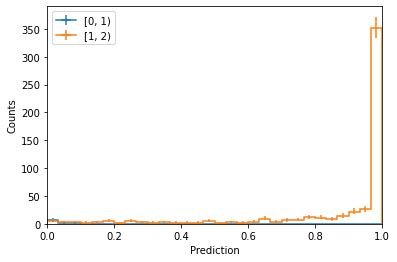

In [18]:
hist.plot1d(prediction_hist.sum('dataset'),overlay='flav')

## scale according to luminosity

In [19]:
nEvents = {}
for d in fileset:
    if not d in nEvents:
        nEvents[d] = 0
    for fName in fileset[d]:
        with uproot.open(fName)['hEvents'] as hEvents:
            nEvents[d] += hEvents.values()[0] + hEvents.values()[2]

print(nEvents)

{'TTGamma': 11005200.0, 'TTbar': 17673700.0}


In [20]:
# cross-section
cx = {'TTGamma':7.509,
      'TTbar': 380.095,}

# weights
lumi_weight = {}
for keyName in fileset:
    lumi_weight[keyName] = (cx[keyName]*580.)/nEvents[keyName]

print(lumi_weight)

{'TTGamma': 0.0003957420128666449, 'TTbar': 0.012473624651318061}


In [21]:
photon_pt_hist.scale(lumi_weight, axis="dataset")

In [22]:
photon_eta_hist.scale(lumi_weight, axis="dataset")
photon_phi_hist.scale(lumi_weight, axis="dataset")
photon_reliso_all_hist.scale(lumi_weight, axis="dataset")
photon_reliso_chg_hist.scale(lumi_weight, axis="dataset")
photon_sieie_hist.scale(lumi_weight, axis="dataset")
photon_r9_hist.scale(lumi_weight, axis="dataset")
photon_hoe_hist.scale(lumi_weight, axis="dataset")
deltaR_photon_lepton_hist.scale(lumi_weight, axis="dataset")
deltaR_photon_jet_hist.scale(lumi_weight, axis="dataset")

photon_mvaid_hist.scale(lumi_weight, axis="dataset")
photon_genPartFlav_hist.scale(lumi_weight, axis="dataset")
prediction_hist.scale(lumi_weight, axis="dataset")

<AxesSubplot:xlabel='Prediction', ylabel='Counts'>

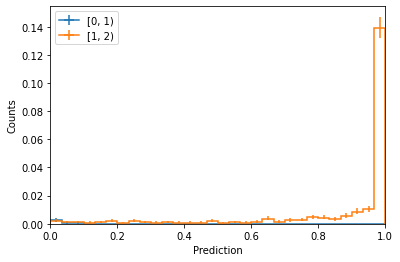

In [23]:
hist.plot1d(prediction_hist.sum('dataset'),overlay='flav')

## try making a processor to do the above

In [64]:
class PhotonPredictor(processor.ProcessorABC):
    def __init__(self):
        
        self.model = load_model('/udrive/student/abraukman2020/PhotonClassification')

        # declare axes
        dataset_axis = hist.Cat("dataset","Dataset")
        flavLabel_axis = hist.Bin("flav",None,[0,1,2])
        photon_genPartFlav_axis = hist.Bin("flav","genPartFlav",14,0,14)
        prediction_axis = hist.Bin("pred","Prediction",30,0,1)
        
        
        # accumulator object: dictionary storing histograms & counters to be filled
        self._accumulator = processor.dict_accumulator({
            'photon_genPartFlav': processor.column_accumulator(np.ndarray(shape=(0,))),
            'prediction': processor.column_accumulator(np.ndarray(shape=(0,))),
            
            'photon_genPartFlav_hist': hist.Hist("Counts", dataset_axis, photon_genPartFlav_axis),
            'prediction_hist': hist.Hist("Counts", dataset_axis, flavLabel_axis, prediction_axis),
        })

    @property
    def accumulator(self):
        return self._accumulator
    
    
    def process(self, events):
        
        output = self.accumulator.identity()
        dataset = events.metadata['dataset']
        
        ######## object & event selection ########
        # muons
        muons=events.Muon
        muonSelectTight = ((muons.pt>30) &
                           (abs(muons.eta)<2.4) &
                           (muons.tightId) &
                           (muons.pfRelIso04_all < 0.15)
                          )
        tightMuons = muons[muonSelectTight]
        
        # jets & b-tagged jets
        jets=events.Jet
        jetSelectTight = ((jets.pt>30) &
                          (abs(jets.eta)<2.4) &
                          (jets.isTight)
                         )
        btaggedJetSelect = (jetSelectTight &
                           (jets.btagDeepB>0.6321)
                          )
        tightJets = jets[jetSelectTight]
        tightBJets = jets[btaggedJetSelect]
        
        # electrons
        electrons=events.Electron
        electronSelectTight = ((electrons.pt> 35) &
                               (abs(electrons.eta)<2.1) &
                               electrons.cutBased>=4 # tight cut-based ID
                              )
        tightEle = electrons[electronSelectTight]
        
        
        # delta R cuts
        phoMu, phoMuDR = events.Photon.nearest(tightMuons,return_metric=True)
        phoMuMask = ak.fill_none(phoMuDR>0.4,True)
        
        phoJet, phoJetDR = events.Photon.nearest(tightJets,return_metric=True)
        phoJetMask = ak.fill_none(phoJetDR>0.4,True)
        
        
        # photons
        photons = events.Photon
        photonSelect= ((photons.pt>20) &
                       (abs(photons.eta) < 1.4442) &
                       (photons.isScEtaEE | photons.isScEtaEB) &
                       (photons.electronVeto) & 
                       np.invert(photons.pixelSeed) &
                       phoMuMask & phoJetMask
                       )
        tightPhotons = photons[photonSelect]
        
        tightPhoMu, tightPhoMuDR = tightPhotons.nearest(tightMuons,return_metric=True)
        tightPhoJet, tightPhoJetDR = tightPhotons.nearest(tightJets,return_metric=True)
        
        
        # events
        trigger = events.HLT.IsoMu24 | events.HLT.IsoTkMu24
        
        eventSelection = (trigger &
                          (ak.num(tightMuons)==1) &
                          (ak.num(tightJets)>=4) & 
                          (ak.num(tightBJets)>=1) &
                          (ak.num(tightEle)==0) &
                          (ak.num(tightPhotons)>=1))

        
        ######## fill histograms ########
        flavLabel = ak.to_numpy(ak.flatten(tightPhotons[eventSelection].genPartFlav))
        flavLabel[flavLabel == 13] = 0 # relabel prompt electrons as fake photons
        
        X = pd.DataFrame({
            'photon_pt': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pt)),
            'photon_eta': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].eta)),
            'photon_phi': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].phi)),
            'photon_hoe': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].hoe)),
            'photon_r9': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].r9)),
            'photon_sieie': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].sieie)),
            'photon_pfRelIso03_all': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_all)),
            'photon_pfRelIso03_chg': ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_chg)),
            'deltaR_photon_lepton': ak.to_numpy(ak.flatten(tightPhoMuDR[eventSelection])),
            'deltaR_photon_jet': ak.to_numpy(ak.flatten(tightPhoJetDR[eventSelection])),
        })
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        #print(ak.to_numpy(ak.flatten(tightPhotons[eventSelection].genPartFlav)).shape, X.shape)
        
        #y = self.model.predict(X_scaled)
        
        #output['photon_genPartFlav_hist'].fill(dataset=dataset,
        #                                       flav=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].genPartFlav)))
        #output['prediction_hist'].fill(dataset=dataset, flav=flavLabel,
        #                               pred=y.reshape(y.shape[0],))
        
        ######## fill column accumulators ########
        #output['photon_genPartFlav'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.genPartFlav[eventSelection])))
        #output['prediction'] = processor.column_accumulator(y.reshape(y.shape[0],))
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [65]:
# Define files to run over
skimDir="/udrive/staff/dnoonan/Skims"

fileset = {"TTGamma":[f"{skimDir}/TTGamma_SingleLept_2016_skim.root"],
           "TTbar":[f"{skimDir}/TTbarPowheg_Semilept_2016_skim_1of10.root",
                    f"{skimDir}/TTbarPowheg_Semilept_2016_skim_2of10.root"]
          }
filesetData = {"DataMu":[f"{skimDir}/Data_SingleMu_b_2016_skim_1of10.root"]
              }

In [66]:
np.warnings.filterwarnings('ignore')

# The NanoAODSchema needs to be adjusted, to remove cross references to FSRPhotons
class SkimmedSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        super().__init__(base_form)

In [67]:
# Run Coffea code using uproot

## Monte Carlo
outputMC = processor.run_uproot_job(
    fileset,
    "Events",
    PhotonPredictor(),
    processor.iterative_executor,
    executor_args={"schema": SkimmedSchema},
    chunksize=100000,
    maxchunks=3,
)

TypeError: cannot pickle '_thread.RLock' object

In [62]:
####### Make arrays